In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(412)

# Define date range
start_date = datetime(2021, 1, 1)
end_date = datetime(2025, 12, 31)

# Generate date range with daily frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate random sales data
# Using a combination of base sales + trend + seasonality + random noise
n_days = len(date_range)

# Base sales around 1000 units
base_sales = 1000

# Add trend component (slight upward trend over time)
trend = np.linspace(0, 200, n_days)

# Add seasonal component (yearly cycle)
seasonal = 150 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)

# Add weekly pattern (higher sales on weekends)
day_of_week = pd.Series(date_range).dt.dayofweek
weekly_pattern = np.where(day_of_week.isin([5, 6]), 100, 0)  # Weekend boost

# Add random noise
noise = np.random.normal(0, 50, n_days)

# Combine all components
sales = base_sales + trend + seasonal + weekly_pattern + noise

# Ensure sales are positive
sales = np.maximum(sales, 0)

# Round to nearest integer
sales = np.round(sales).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'sales': sales
})

# Display first and last few rows
print("Dataset created successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nLast 10 rows:")
print(df.tail(10))

# Basic statistics
print(f"\nBasic Statistics:")
print(df['sales'].describe())

# Save to CSV file
csv_filename = 'sales_data_2023_2025_v2.csv'
df.to_csv(csv_filename, index=False)
print(f"\nDataset saved to '{csv_filename}'")





Dataset created successfully!

Dataset shape: (1826, 2)
Date range: 2021-01-01 00:00:00 to 2025-12-31 00:00:00

First 10 rows:
        date  sales
0 2021-01-01   1004
1 2021-01-02   1080
2 2021-01-03   1103
3 2021-01-04    942
4 2021-01-05    960
5 2021-01-06   1048
6 2021-01-07   1007
7 2021-01-08   1146
8 2021-01-09   1003
9 2021-01-10   1076

Last 10 rows:
           date  sales
1816 2025-12-22   1161
1817 2025-12-23   1223
1818 2025-12-24   1194
1819 2025-12-25   1207
1820 2025-12-26   1150
1821 2025-12-27   1233
1822 2025-12-28   1331
1823 2025-12-29   1144
1824 2025-12-30   1163
1825 2025-12-31   1181

Basic Statistics:
count    1826.000000
mean     1126.820372
std       130.983201
min       781.000000
25%      1027.000000
50%      1128.500000
75%      1222.750000
max      1515.000000
Name: sales, dtype: float64

Dataset saved to 'sales_data_2023_2025_v2.csv'


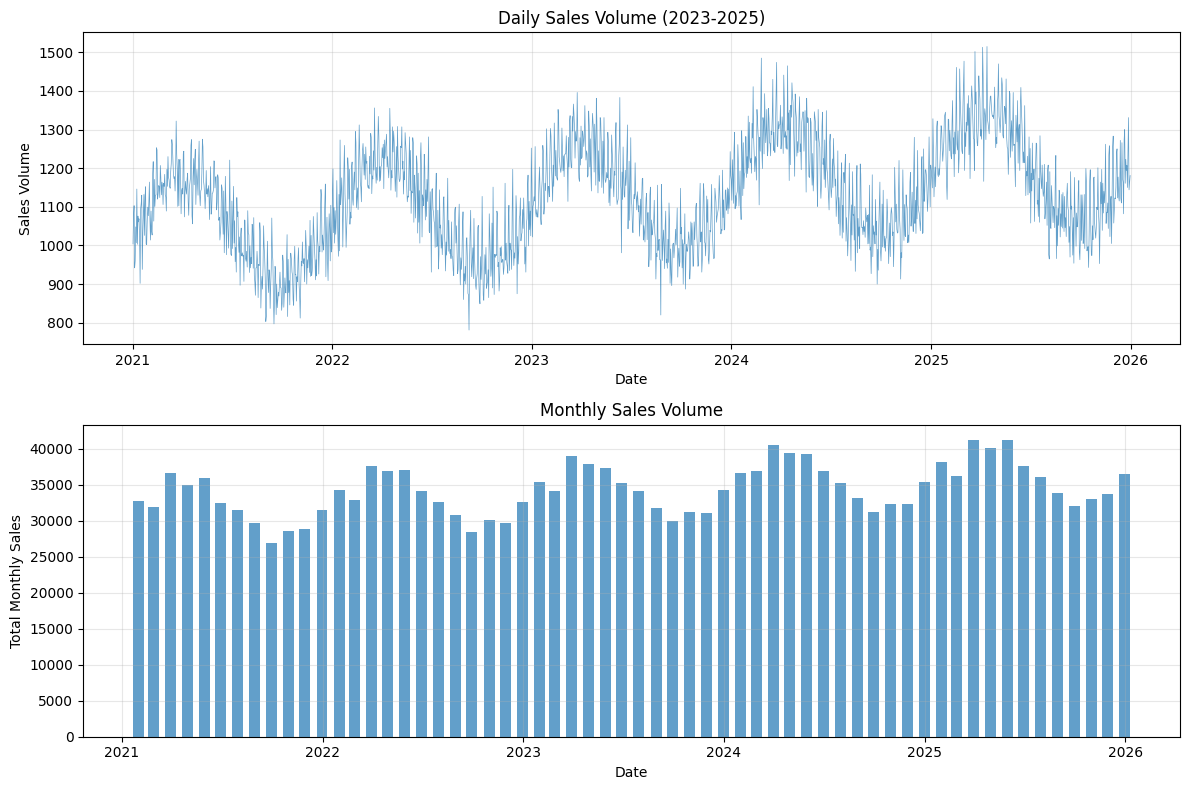


Visualization saved to 'sales_visualization_v2.png'


In [12]:
# Create a simple visualization
try:
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Full time series
    axes[0].plot(df['date'], df['sales'], linewidth=0.5, alpha=0.7)
    axes[0].set_title('Daily Sales Volume (2023-2025)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales Volume')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Monthly aggregated sales
    df_monthly = df.set_index('date').resample('ME')['sales'].sum().reset_index()
    axes[1].bar(df_monthly['date'], df_monthly['sales'], width=20, alpha=0.7)
    axes[1].set_title('Monthly Sales Volume')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Total Monthly Sales')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sales_visualization_v2.png', dpi=100)
    plt.show()
    print("\nVisualization saved to 'sales_visualization_v2.png'")
    
except ImportError:
    print("\nNote: Install matplotlib for visualization (pip install matplotlib)")

In [13]:
import mlflow
import mlflow.prophet
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from dotenv import load_dotenv
import datetime
# Load environment variables from .env file
load_dotenv()


experiment_name = "/Users/j.huertas@closerstillmedia.com/prophet"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

experiment exists


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3039328626124250', creation_time=1755624146266, experiment_id='3039328626124250', last_update_time=1755630146918, lifecycle_stage='active', name='/Users/j.huertas@closerstillmedia.com/prophet', tags={'mlflow.databricks.filesystem.experiment_permissions_check': 'test',
 'mlflow.experiment.sourceName': '/Users/j.huertas@closerstillmedia.com/prophet',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'b.relf@closerstillmedia.com',
 'mlflow.ownerId': '7931383772120950'}>

In [14]:
def prepare_prophet_data(data, date_col, value_col, freq="D"):
    """
    Prepare data for Prophet training.

    Args:
        data: DataFrame with time series data
        date_col: Name of date column
        value_col: Name of value column
        freq: Frequency of the time series
    """

    # Prophet requires columns named 'ds' (datestamp) and 'y' (value)
    prophet_df = data[[date_col, value_col]].copy()
    prophet_df.columns = ["ds", "y"]

    # Ensure ds is datetime
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

    # Sort by date
    prophet_df = prophet_df.sort_values("ds").reset_index(drop=True)

    # Handle missing dates if needed
    if freq:
        full_date_range = pd.date_range(
            start=prophet_df["ds"].min(), end=prophet_df["ds"].max(), freq=freq
        )

        # Reindex to fill missing dates
        prophet_df = prophet_df.set_index("ds").reindex(full_date_range).reset_index()
        prophet_df.columns = ["ds", "y"]

        # Log data quality metrics
        missing_dates = prophet_df["y"].isna().sum()
        print(f"Missing dates filled: {missing_dates}")

    return prophet_df

    
df_prepared = prepare_prophet_data(df, 'date', 'sales', freq='D')
df_prepared.head()

Missing dates filled: 0


,ds,y
0,2021-01-01,1004
1,2021-01-02,1080
2,2021-01-03,1103
3,2021-01-04,942
4,2021-01-05,960


# Seasonality and Trend Configuration

In [15]:
def advanced_prophet_configuration():
    """Demonstrate advanced Prophet configuration options."""

    with mlflow.start_run(run_name="Advanced Prophet Configuration"):
        # Create Prophet model with advanced settings
        model = Prophet(
            # Trend configuration
            growth="logistic",  # or 'linear'
            changepoints=None,  # Let Prophet auto-detect, or specify dates
            n_changepoints=25,  # Number of potential changepoints
            changepoint_range=0.8,  # Proportion of history for changepoints
            changepoint_prior_scale=0.05,  # Flexibility of trend changes
            # Seasonality configuration
            yearly_seasonality="auto",  # or True/False/number
            weekly_seasonality="auto",
            daily_seasonality="auto",
            seasonality_mode="additive",  # or 'multiplicative'
            seasonality_prior_scale=10,
            # Holiday configuration
            holidays_prior_scale=10,
            # Uncertainty configuration
            interval_width=0.80,  # Width of uncertainty intervals
            uncertainty_samples=1000,  # Monte Carlo samples for uncertainty
            # Stan configuration
            mcmc_samples=0,  # Use MAP instead of MCMC
            stan_backend="CMDSTANPY",  # Stan backend
        )

        # For logistic growth, need to specify capacity
        if model.growth == "logistic":
            df_prepared["cap"] = df_prepared["y"].max() * 1.2  # Set capacity 20% above max observed
            df_prepared["floor"] = 0  # Optional floor

        # Fit the model
        model.fit(df_prepared)

        # Log configuration parameters
        config_params = {
            "growth": model.growth,
            "n_changepoints": model.n_changepoints,
            "changepoint_range": model.changepoint_range,
            "seasonality_mode": model.seasonality_mode,
            "interval_width": model.interval_width,
        }
        mlflow.log_params(config_params)

        return model


# Usage
advanced_model = advanced_prophet_configuration()

20:06:49 - cmdstanpy - INFO - Chain [1] start processing
20:06:49 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run Advanced Prophet Configuration at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d03c275b23494f09ab465109aaa45b35
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


# Cross-Validation Best Practices

In [16]:
def comprehensive_model_validation(model, df):
    """Perform comprehensive Prophet model validation."""

    with mlflow.start_run(run_name="Comprehensive Model Validation"):
        # Multiple cross-validation configurations
        cv_configs = [
            {
                "name": "short_horizon",
                "initial": "365 days",
                "period": "90 days",
                "horizon": "90 days",
            },
            {
                "name": "medium_horizon",
                "initial": "730 days",
                "period": "180 days",
                "horizon": "180 days",
            },
            {
                "name": "long_horizon",
                "initial": "1095 days",
                "period": "180 days",
                "horizon": "365 days",
            },
        ]

        all_metrics = {}

        for config in cv_configs:
            try:
                # Perform cross-validation
                cv_results = cross_validation(
                    model,
                    initial=config["initial"],
                    period=config["period"],
                    horizon=config["horizon"],
                    parallel="threads",
                )

                # Calculate metrics
                metrics = performance_metrics(cv_results)
                avg_metrics = metrics[["mse", "rmse", "mae", "mape", "coverage"]].mean()

                # Store metrics with configuration prefix
                for metric, value in avg_metrics.items():
                    metric_name = f"{config['name']}_{metric}"
                    all_metrics[metric_name] = value
                    mlflow.log_metric(metric_name, value)

                # Log additional statistics
                mlflow.log_metrics(
                    {
                        f"{config['name']}_cv_folds": len(cv_results),
                        f"{config['name']}_mape_std": metrics["mape"].std(),
                    }
                )

            except Exception as e:
                print(f"Cross-validation failed for {config['name']}: {e}")
                mlflow.log_param(f"{config['name']}_error", str(e))

        return all_metrics


# Usage
validation_metrics = comprehensive_model_validation(advanced_model, df_prepared)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:06:54 - cmdstanpy - INFO - Chain [1] start processing
20:06:54 - cmdstanpy - INFO - Chain [1] done processing
20:06:54 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start p

🏃 View run Comprehensive Model Validation at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/5c92b53eed9c48c4b1545204e57525ad
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


In [17]:
validation_metrics

{'short_horizon_mse': 2578.543363545984,
 'short_horizon_rmse': 50.71087187873515,
 'short_horizon_mae': 40.699088758513255,
 'short_horizon_mape': 0.036044914294543845,
 'short_horizon_coverage': 0.7599932249322494,
 'medium_horizon_mse': 2655.5392826286616,
 'medium_horizon_rmse': 51.45126835946424,
 'medium_horizon_mae': 41.29076392076078,
 'medium_horizon_mape': 0.03590280801868008,
 'medium_horizon_coverage': 0.7524426266757556,
 'long_horizon_mse': 2807.593187291737,
 'long_horizon_rmse': 52.899131266566805,
 'long_horizon_mae': 42.389621774665684,
 'long_horizon_mape': 0.03627188588769864,
 'long_horizon_coverage': 0.7303384363700585}

# Forecast Quality Assessment


In [22]:
! uv pip install seaborn statsmodels

Resolved 18 packages in 159ms
Prepared 1 package in 4.37s
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 2 packages in 1.94s
 + patsy==1.0.1
 + statsmodels==0.14.5


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_forecast_quality(model, df):
    """Analyze forecast quality with visualizations."""

    with mlflow.start_run(run_name="Forecast Quality Analysis"):
        # Generate forecast
        future = model.make_future_dataframe(periods=365)
        if model.growth == "logistic":
            future["cap"] = df["cap"].iloc[-1]  # Use last known capacity
            future["floor"] = df["floor"].iloc[-1] if "floor" in df.columns else 0

        forecast = model.predict(future)

        # Component analysis
        fig = model.plot_components(forecast, figsize=(12, 8))
        plt.tight_layout()
        plt.savefig("forecast_components.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("forecast_components.png")
        plt.close()

        # Forecast plot
        fig = model.plot(forecast, figsize=(12, 6))
        plt.title("Prophet Forecast")
        plt.tight_layout()
        plt.savefig("forecast_plot.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("forecast_plot.png")
        plt.close()

        # Residual analysis
        # Get historical predictions
        historical_forecast = forecast[forecast["ds"] <= df["ds"].max()]
        residuals = (
            df.set_index("ds")["y"] - historical_forecast.set_index("ds")["yhat"]
        )

        # Plot residuals
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Residuals over time
        axes[0, 0].plot(residuals.index, residuals.values)
        axes[0, 0].set_title("Residuals Over Time")
        axes[0, 0].set_xlabel("Date")
        axes[0, 0].set_ylabel("Residual")

        # Residual distribution
        axes[0, 1].hist(residuals.values, bins=30, alpha=0.7)
        axes[0, 1].set_title("Residual Distribution")
        axes[0, 1].set_xlabel("Residual")
        axes[0, 1].set_ylabel("Frequency")

        # Q-Q plot
        from scipy import stats
        from statsmodels.stats import diagnostic as diag

        stats.probplot(residuals.values, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title("Q-Q Plot")

        # Residuals vs fitted
        axes[1, 1].scatter(historical_forecast["yhat"], residuals.values, alpha=0.6)
        axes[1, 1].set_title("Residuals vs Fitted")
        axes[1, 1].set_xlabel("Fitted Values")
        axes[1, 1].set_ylabel("Residuals")

        plt.tight_layout()
        plt.savefig("residual_analysis.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("residual_analysis.png")
        plt.close()

        # Calculate residual statistics
        residual_stats = {
            "residual_mean": residuals.mean(),
            "residual_std": residuals.std(),
            "residual_skewness": stats.skew(residuals.values),
            "residual_kurtosis": stats.kurtosis(residuals.values),
            "ljung_box_pvalue": diag.acorr_ljungbox(
                residuals.values, lags=10, return_df=True
            )["lb_pvalue"].iloc[-1],
        }

        mlflow.log_metrics(residual_stats)

        return forecast, residual_stats


# Usage
forecast_analysis, residual_stats = analyze_forecast_quality(advanced_model, df_prepared)

🏃 View run Forecast Quality Analysis at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/5a5c4b113ef749abb4ddd6cd21de3a4e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250
